In [1]:
# in a Python cell
!pip install nvcc4jupyter
%load_ext nvcc4jupyter

Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmp1c0vhzvb".


In [4]:

%%cuda
// conv2d_timed_print_json.cu

#include <iostream>
#include <vector>
#include <chrono>
#include <fstream>
#include <iomanip>
#include <cuda_runtime.h>

#define TILE_SIZE 16

// CUDA convolution kernel
__global__ void conv_per_img(
    const float* __restrict__ img,
    const float* __restrict__ kernel,
    float* __restrict__ out,
    int in_x, int in_y,
    int mask_size)
{
    extern __shared__ float sh[];
    float* sImage  = sh;
    float* sKernel = sh + TILE_SIZE * TILE_SIZE;

    int x  = blockIdx.x * blockDim.x + threadIdx.x;
    int y  = blockIdx.y * blockDim.y + threadIdx.y;
    int tx = threadIdx.x, ty = threadIdx.y;

    // load image pixel into shared memory
    if (x < in_x && y < in_y)
        sImage[tx * TILE_SIZE + ty] = img[x * in_y + y];
    else
        sImage[tx * TILE_SIZE + ty] = 0.0f;

    // load kernel into shared memory
    if (tx < mask_size && ty < mask_size)
        sKernel[tx * mask_size + ty] = kernel[tx * mask_size + ty];

    __syncthreads();

    int out_x = in_x - mask_size + 1;
    int out_y = in_y - mask_size + 1;

    if (x < in_x && y < in_y) {
        for (int i = 0; i < mask_size; ++i) {
            for (int j = 0; j < mask_size; ++j) {
                int ox = x - i, oy = y - j;
                if (ox >= 0 && ox < out_x && oy >= 0 && oy < out_y) {
                    atomicAdd(&out[ox * out_y + oy],
                              sImage[tx * TILE_SIZE + ty] *
                              sKernel[i * mask_size + j]);
                }
            }
        }
    }
}

// CPU reference convolution
void convolve2d_cpu(
    const float* in, int in_x, int in_y,
    const float* ker, int m,
    float* out)
{
    int out_x = in_x - m + 1, out_y = in_y - m + 1;
    for (int i = 0; i < out_x; ++i) {
        for (int j = 0; j < out_y; ++j) {
            float sum = 0.0f;
            for (int ii = 0; ii < m; ++ii)
                for (int jj = 0; jj < m; ++jj)
                    sum += in[(i+ii)*in_y + (j+jj)] * ker[ii*m + jj];
            out[i*out_y + j] = sum;
        }
    }
}

int main() {
    std::vector<int> sizes = {100, 1000, 10000};
    std::vector<int> masks = {3, 5, 10};

    // Prepare JSON file
    std::ofstream fout("TIMINGS.json");
    if (!fout) {
        std::cerr << "Error: cannot open TIMINGS.json for writing\n";
        return 1;
    }
    fout << "{\n";
    bool first_json = true;

    // Header for console
    std::cout << std::left
              << std::setw(12) << "Case"
              << " | " << std::setw(6) << "Mask"
              << " | " << std::setw(10) << "CPU (s)"
              << " | " << std::setw(10) << "GPU (s)"
              << "\n";
    std::cout << std::string(60, '-') << "\n";

    for (int X : sizes) {
      for (int Y : sizes) {
        for (int M : masks) {
          int out_x = X - M + 1, out_y = Y - M + 1;
          size_t img_sz = X * Y;
          size_t ker_sz = M * M;
          size_t out_sz = out_x * out_y;

          // Host buffers
          std::vector<float> h_img(img_sz), h_ker(ker_sz),
                             h_out_cpu(out_sz, 0.0f),
                             h_out_gpu(out_sz, 0.0f);

          // Initialize data
          for (size_t i = 0; i < img_sz; ++i)
            h_img[i] = static_cast<float>(rand())/RAND_MAX * 255.0f;
          for (size_t i = 0; i < ker_sz; ++i)
            h_ker[i] = static_cast<float>(rand())/RAND_MAX * 2.0f - 1.0f;

          // Device buffers
          float *d_img, *d_ker, *d_out;
          cudaMalloc(&d_img, img_sz * sizeof(float));
          cudaMalloc(&d_ker, ker_sz * sizeof(float));
          cudaMalloc(&d_out, out_sz * sizeof(float));
          cudaMemcpy(d_img, h_img.data(), img_sz * sizeof(float), cudaMemcpyHostToDevice);
          cudaMemcpy(d_ker, h_ker.data(), ker_sz * sizeof(float), cudaMemcpyHostToDevice);
          cudaMemset(d_out, 0, out_sz * sizeof(float));

          // GPU timing with events
          cudaEvent_t start, stop;
          cudaEventCreate(&start);
          cudaEventCreate(&stop);

          dim3 block(TILE_SIZE, TILE_SIZE);
          dim3 grid((X + TILE_SIZE - 1) / TILE_SIZE,
                    (Y + TILE_SIZE - 1) / TILE_SIZE);
          size_t shared_mem = TILE_SIZE*TILE_SIZE*sizeof(float)
                              + M*M*sizeof(float);

          cudaEventRecord(start);
          conv_per_img<<<grid, block, shared_mem>>>(d_img, d_ker, d_out, X, Y, M);
          cudaEventRecord(stop);
          cudaEventSynchronize(stop);
          float gpu_ms = 0.0f;
          cudaEventElapsedTime(&gpu_ms, start, stop);
          double gpu_s = gpu_ms / 1000.0;

          // Copy back result (not timed)
          cudaMemcpy(h_out_gpu.data(), d_out, out_sz * sizeof(float), cudaMemcpyDeviceToHost);

          // CPU timing
          auto t0 = std::chrono::high_resolution_clock::now();
          convolve2d_cpu(h_img.data(), X, Y, h_ker.data(), M, h_out_cpu.data());
          auto t1 = std::chrono::high_resolution_clock::now();
          double cpu_s = std::chrono::duration<double>(t1 - t0).count();

          // Console print
          std::cout << std::left
                    << std::setw(12) << (std::to_string(X)+"x"+std::to_string(Y))
                    << " | " << std::setw(6) << M
                    << " | " << std::setw(10) << cpu_s
                    << " | " << std::setw(10) << gpu_s
                    << "\n";

          // JSON entry
          if (!first_json) fout << ",\n";
          fout << "  \"" << X << "x" << Y << "_" << M << "\": {"
               << "\"cpu\": " << cpu_s << ", "
               << "\"gpu\": " << gpu_s << "}";
          first_json = false;

          // Cleanup
          cudaEventDestroy(start);
          cudaEventDestroy(stop);
          cudaFree(d_img);
          cudaFree(d_ker);
          cudaFree(d_out);
        }
      }
    }

    fout << "\n}\n";
    fout.close();
    std::cout << "\n✅ TIMINGS.json written\n";
    return 0;
}


Case         | Mask   | CPU (s)    | GPU (s)   
------------------------------------------------------------
100x100      | 3      | 0.000322033 | 0.00757146
100x100      | 5      | 0.000804167 | 3.072e-06 
100x100      | 10     | 0.00272687 | 2.304e-06 
100x1000     | 3      | 0.00327497 | 2.464e-06 
100x1000     | 5      | 0.00818554 | 2.048e-06 
100x1000     | 10     | 0.0312977  | 2.464e-06 
100x10000    | 3      | 0.0327893  | 3.136e-06 
100x10000    | 5      | 0.0838759  | 2.08e-06  
100x10000    | 10     | 0.297682   | 2.528e-06 
1000x100     | 3      | 0.00329454 | 5.504e-06 
1000x100     | 5      | 0.00815728 | 2.176e-06 
1000x100     | 10     | 0.0304203  | 2.368e-06 
1000x1000    | 3      | 0.0330564  | 2.752e-06 
1000x1000    | 5      | 0.084437   | 2.048e-06 
1000x1000    | 10     | 0.334909   | 2.048e-06 
1000x10000   | 3      | 0.33701    | 2.464e-06 
1000x10000   | 5      | 0.895622   | 2.528e-06 
1000x10000   | 10     | 3.541      | 2.528e-06 
10000x100    | 3      | 0

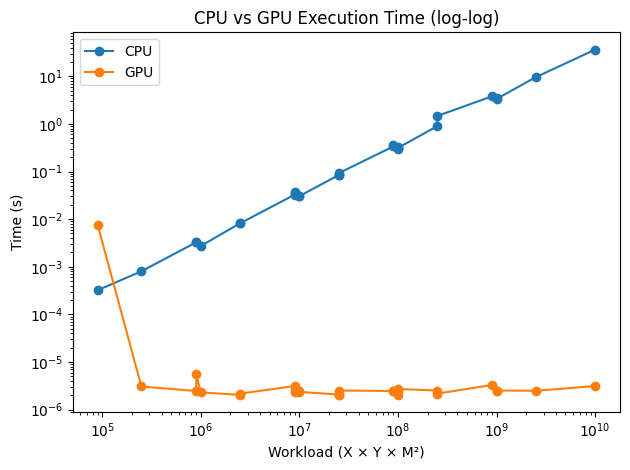

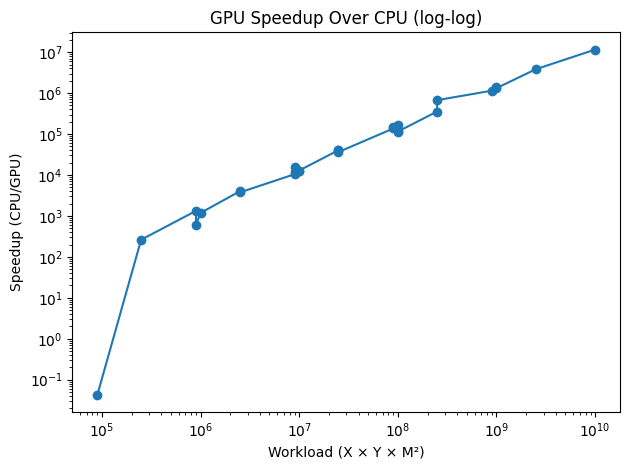

In [5]:
import json
import matplotlib.pyplot as plt

# Load timings
with open('TIMINGS.json') as f:
    timings = json.load(f)

# Parse numeric workload = X * Y * M^2
data = []
for case, vals in timings.items():
    dims, m_str = case.split('_')
    x_str, y_str = dims.split('x')
    x, y, m = int(x_str), int(y_str), int(m_str)
    workload = x * y * m * m
    data.append((workload, vals['cpu'], vals['gpu'], case))

# Sort by workload
data.sort(key=lambda t: t[0])
workloads = [t[0] for t in data]
cpu_times = [t[1] for t in data]
gpu_times = [t[2] for t in data]
speedups = [c/g for c, g in zip(cpu_times, gpu_times)]

# Plot CPU vs GPU times on log-log scale
plt.figure()
plt.plot(workloads, cpu_times, marker='o', label='CPU')
plt.plot(workloads, gpu_times, marker='o', label='GPU')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Workload (X × Y × M²)')
plt.ylabel('Time (s)')
plt.title('CPU vs GPU Execution Time (log-log)')
plt.legend()
plt.tight_layout()
plt.show()

# Plot speedup on log-log scale
plt.figure()
plt.plot(workloads, speedups, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Workload (X × Y × M²)')
plt.ylabel('Speedup (CPU/GPU)')
plt.title('GPU Speedup Over CPU (log-log)')
plt.tight_layout()
plt.show()